In [ ]:
!pip install langchain-fireworks

In [1]:
import os
import sys
import logging
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
from typing import List, Dict, Any

from dotenv import load_dotenv
from langchain_sambanova import ChatSambaStudio, ChatSambaNovaCloud
from langchain_fireworks import ChatFireworks 
from langchain_core.prompts import PromptTemplate

current_dir = os.getcwd()
kit_dir = os.path.abspath(os.path.join(current_dir, '..'))
repo_dir = os.path.abspath(os.path.join(kit_dir, '..'))

sys.path.append(kit_dir)
sys.path.append(repo_dir)

load_dotenv(os.path.join(repo_dir, '.env'), override=True)

/Users/jorgep/Documents/ask_public_own/guardenv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in SambaStudioEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


True

# Set LLMs

In [2]:
# chat models to evaluate

llm_sambanova_cloud = ChatSambaNovaCloud(
    max_tokens=1024, 
    model='Meta-Llama-3.1-8B-Instruct',
    temperature=0.01
    )

llm_sambastudio = ChatSambaStudio(
    max_tokens=1024, 
    model='Meta-Llama-3.1-8B-Instruct',
    temperature=0.01
    )

llm_provider1 = ChatFireworks(
    max_tokens=1024, 
    model="accounts/fireworks/models/llama-v3p1-8b-instruct",
    temperature=0.01
)

# Set Guardrails models

In [3]:
# guardrail models to evaluate

guardrails_sambanova_cloud = ChatSambaNovaCloud(
    max_tokens=4096, 
    model='Meta-Llama-Guard-3-8B',
    temperature=0.01
    )

guardrails_sambastudio = ChatSambaStudio(
    max_tokens=4096, 
    model='Meta-Llama-Guard-3-8B',
    temperature=0.01,
    )

guardrails_provider1 = ChatFireworks(
    max_tokens=4096, 
    model='accounts/fireworks/models/llama-guard-3-8b',
    temperature=0.01
)

# Guardrails evaluation methods

In [4]:
unsafe_categories = """S1: Violent Crimes.
AI models should not create content that enables, encourages, or excuses the commission of violent crimes. Examples of violent crimes include, but are not limited to:
- Unlawful violence toward people (ex: terrorism, genocide, murder, hate crimes, child abuse, assault, battery, kidnapping)
- Unlawful violence toward animals (ex: animal abuse)
S2: Non-Violent Crimes.
AI models should not create content that enables, encourages, or excuses the commission of non-violent crimes. Examples of non-violent crimes include, but are not limited to:
- Financial crimes (ex: fraud, scams, money laundering)
- Property crimes (ex: burglary, robbery, arson, vandalism)
- Drug crimes (ex: creating or trafficking narcotics)
- Weapons crimes (ex: producing unlicensed firearms)
- Cyber crimes (ex: hacking, spyware, malware)
S3: Sex Crimes.
AI models should not create content that enables, encourages, or excuses the commission of sex crimes. Examples of sex crimes include, but are not limited to:
- Human trafficking
- Sexual assault (ex: rape)
- Sexual harassment (ex: groping)
- Lewd conduct
S4: Child Exploitation.
AI models should not create content that depicts child nudity or that enables, encourages, excuses, or depicts the sexual abuse of children.
S5: Specialized Advice.
AI models should not create content that contains specialized financial, medical, or legal advice.
S6: Privacy.
AI models should not create content that contains sensitive, personal information about private individuals.
S7: Intellectual Property.
AI models should not create content that violates the intellectual property rights of third parties.
S8: Indiscriminate Weapons.
AI models should not create content that enables the creation of weapons of mass destruction. Examples of such weapons include, but are not limited to:
- Chemical weapons (ex: nerve gas)
- Biological weapons (ex: anthrax)
- Radiological weapons (ex: salted bombs)
- Nuclear weapons (ex: atomic warheads)
- High-yield explosive weapons (ex: cluster munitions)
S9: Hate.
AI models should not create content that is hateful toward people on the basis of their protected characteristics (race, color, ethnicity, national origin, disability, religious affiliation, caste, sexual orientation, sex, gender identity and serious disease). AI models should not create content that perpetuates negative stereotypes.
S10: Self-Harm.
AI models should not create content that enables, encourages, or excuses acts of intentional self-harm. Examples of such actions include, but are not limited to:
- Suicide
- Self-injury (ex: cutting)
- Disordered eating
S11: Sexual Content.
AI models should not create depictions of nude adults or content that contains erotic descriptions or explicit depictions of sex acts.
<END UNSAFE CONTENT CATEGORIES>
)"""

def evaluate_guardrails(guardrails_model, input, role, unsafe_categories=unsafe_categories):
    guardrails_prompt_template = PromptTemplate.from_template(
        """<|begin_of_text|>[INST] Task: Check if there is unsafe content in '{role}' messages in conversations according our safety policy with the below categories.

        <BEGIN UNSAFE CONTENT CATEGORIES>
        {unsafe_categories}
        <END UNSAFE CONTENT CATEGORIES>

        <BEGIN CONVERSATION>

        {conversation}
        <END CONVERSATION>

        Provide your safety assessment for ONLY THE LAST {role} in the above conversation:
        - First line must read 'safe' or 'unsafe'.
        - If unsafe, a second line must include a comma-separated list of violated categories. [/INST]"""
    )
    if isinstance(input, str):
        conversation = f"{role.capitalize()}: {input}\n\n"
    elif isinstance(input, list):
        conversation = ""
        for turn in conversation:
            conversation += f"{turn['role'].capitalize()}: {turn['content']}\n\n"
        
    prompt = guardrails_prompt_template.format(
        unsafe_categories = unsafe_categories,
        conversation= conversation,
        role = role
    )
    
    return guardrails_model.invoke(prompt)

# Workflow with Guardrails methods

In [5]:
def invoke_with_guardrails_metrics(llm, guardrails_model, prompt):
    response = {}
    client_latencies={}
    client_latencies["start_time"] = time.time()
    guardrails_user_response = evaluate_guardrails(guardrails_model, prompt, role = "user")
    response["guardrails_user_response"]=guardrails_user_response
    client_latencies["user_guardrails_end_time"] = time.time()
    client_latencies["user_guardrails_time"] = client_latencies["user_guardrails_end_time"]-client_latencies["start_time"]
    if guardrails_user_response.content.strip().split("\n")[0] == "unsafe":
        logging.warning("User input {} has violated guardrails: {}".format(prompt, guardrails_user_response.content.replace('\n', ' ')))
        response["client_latencies"]=client_latencies
        return response
    llm_response = llm.invoke(prompt)
    response["llm_response"]=llm_response
    client_latencies["llm_generation_end_time"] = time.time()
    client_latencies["llm_generation_time"] = client_latencies["llm_generation_end_time"]-client_latencies["user_guardrails_end_time"]
    client_latencies["end_time_2_calls"] = client_latencies["llm_generation_end_time"]
    client_latencies["e2e_2_calls_time"] = client_latencies["end_time_2_calls"]-client_latencies["start_time"]
    guardrails_assistant_response = evaluate_guardrails(
        guardrails_model,
        [{
            "user": prompt, 
            "assistant": llm_response.content 
        }],
        role = "assistant"
        )
    response["guardrails_assistant_response"]=guardrails_assistant_response
    client_latencies["assistant_guardrails_end_time"] = time.time()
    client_latencies["assistant_guardrails_time"] = client_latencies["assistant_guardrails_end_time"]-client_latencies["llm_generation_end_time"]
    client_latencies["end_time_3_calls"] = client_latencies["assistant_guardrails_end_time"]
    client_latencies["e2e_3_calls_time"] = client_latencies["end_time_3_calls"]-client_latencies["start_time"]
    if guardrails_assistant_response.content.strip().split("\n")[0] == "unsafe":
        logging.warning("Model response {} has violated guardrails: {}".format(llm_response.content, guardrails_assistant_response.content.replace('\n', ' ')))
    response["client_latencies"]=client_latencies
    return response

# Benchmark methods

In [6]:
def call_providers_in_parallel(prompt, sambastudio=True, sambanovacloud=True, provider1=True):
    responses={}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        if sambanovacloud:
            future_sambanovacloud = executor.submit(invoke_with_guardrails_metrics, llm_sambanova_cloud, guardrails_sambanova_cloud, prompt)
        if sambastudio:
            future_sambastudio = executor.submit(invoke_with_guardrails_metrics, llm_sambastudio, guardrails_sambastudio, prompt) 
        if provider1:
            future_provider1 = executor.submit(invoke_with_guardrails_metrics, llm_provider1, guardrails_provider1, prompt)

        if sambanovacloud:
            sambanovacloud_workflow_response = future_sambanovacloud.result()
            responses["sambanovacloud"] =sambanovacloud_workflow_response
        if sambastudio:
            sambastudio_workflow_response = future_sambastudio.result()
            responses["sambastudio"] = sambastudio_workflow_response
        if provider1:
            provider1_workflow_response = future_provider1.result()
            responses["provider1"] = provider1_workflow_response
    return responses


In [7]:
def run_benchmark(prompts, iterations, sambastudio=True, sambanovacloud=True, provider1=True):
    results = []
    for it in range(iterations):
        print(f"running iteration {it}")
        for id, prompt in enumerate(prompts): 
            print(f"\trunning prompt {id}")
            results.append(call_providers_in_parallel(prompt,sambastudio, sambanovacloud, provider1))
    return results

# Analyze and plot metrics methods

In [8]:
def get_metrics_as_table(runs: List[Dict[str,Any]]) -> pd.DataFrame:    
    # Extract data and organize into a DataFrame
    data = []
    for run_idx, run in enumerate(runs):
        for provider, metrics in run.items():
            latencies = metrics['client_latencies']
            latencies = {key:value for key,value in latencies.items() if key in ['user_guardrails_time', 'llm_generation_time', 'assistant_guardrails_time', 'e2e_2_calls_time', 'e2e_3_calls_time']}
            data.append({"Run": run_idx + 1, "Provider": provider, **latencies})
    return pd.DataFrame(data)

def get_stats(df: pd.DataFrame) -> pd.DataFrame:
    stats = df.groupby("Provider")[['user_guardrails_time', 'llm_generation_time', 'assistant_guardrails_time', 'e2e_2_calls_time', 'e2e_3_calls_time']].agg(['mean', 'std', 'min', 'max'])
    return stats

def plot_comparison_barcharts_2_calls(df: pd.DataFrame) -> None:
    # Plot bar charts comparing providers
    latency_columns = ['user_guardrails_time', 'llm_generation_time', 'e2e_2_calls_time']
    latency_columns_titles = {
        'user_guardrails_time': "Latency comparison: Guardrails on User's Prompt" , 
        'llm_generation_time': "Latency comparison: LLM generation" ,  
        'e2e_2_calls_time': 'E2E Latency comparison for 2 calls workflow'
    }
    _, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for idx, col in enumerate(latency_columns):
        ax = axes[idx]
        sns.barplot(
            data=df, 
            x="Provider", 
            y=col, 
            hue="Provider",
            ax=ax, 
            legend=False,
            estimator='mean',
            errorbar=('pi', 50)
        )
        ax.set_title(latency_columns_titles[col])
        ax.set_ylabel("Time (s)")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show();
    
def newplot(df):
    stacked_data = df.melt(id_vars=["Provider", "Run"], 
                       value_vars=['user_guardrails_time', 'llm_generation_time', 'assistant_guardrails_time'], 
                       var_name="Latency Type", 
                       value_name="Time (s)")

    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=stacked_data, 
        x="Provider", 
        y="Time (s)", 
        hue="Latency Type", 
        ci="sd", 
        palette="viridis"
    )
    plt.title("Stacked Latency Times per Provider")
    plt.ylabel("Time (s)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Latency Type")
    plt.tight_layout()
    plt.show()
    
def plot_comparison_barcharts(df: pd.DataFrame) -> None:
    # Plot bar charts comparing providers
    latency_columns = ['e2e_2_calls_time', 'e2e_3_calls_time']
    latency_columns_titles = {
        'e2e_2_calls_time': 'E2E Latency for 2 API Calls',
        'e2e_3_calls_time': 'E2E Latency for 3 API Calls'
    }
    _, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes = axes.ravel()

    # Initialize lists to hold the y-values across both charts
    y_min, y_max = float('inf'), float('-inf')

    for idx, col in enumerate(latency_columns):
        ax = axes[idx]
        sns.barplot(
            data=df, 
            x="Provider", 
            y=col, 
            hue="Provider",
            ax=ax, 
            legend=False,
            estimator='mean',
            errorbar=('pi', 50),
        )
        ax.set_title(latency_columns_titles[col])
        ax.set_ylabel("Time (s)")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Update the min and max y-values based on the current chart
        y_min = min(y_min, df[col].min() - 1 if df[col].min() - 1 > 0 else 0)
        y_max = max(y_max, df[col].max() + 1)

    # Set the same y-axis range for both plots
    for ax in axes:
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()
    
def plot_comparison_stacked_barplots(df: pd.DataFrame) -> None:
    # Set the 'Provider' column as index and transpose the DataFrame for easier plotting
    data_for_plot = df.set_index(["Run", "Provider"])[
        [
            "user_guardrails_time",
            "llm_generation_time",
            "assistant_guardrails_time",
        ]
    ]

    # Unstack to separate the Providers
    stacked_data = data_for_plot.unstack("Run")
    mean_values = stacked_data.T.groupby(level=0).mean().T
    mean_values.sort_index(ascending=True)

    # Plot the stacked bar plot
    ax = mean_values.plot(
        kind="bar", stacked=True, figsize=(10, 6), cmap="summer", edgecolor="black"
    )

    # Add labels for each stack segment
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
        x_position = p.get_x() + width / 2
        y_position = p.get_y() + height / 2
        
        # Place the label inside the bar segment
        ax.text(
            x_position, y_position, f'{height:.2f}', 
            ha="center", va="center", color="black", fontsize=8
        )

    custom_legend_labels = [
        "User Guardrails Time", 
        "LLM Generation Time", 
        "Assistant Guardrails Time"
    ]
     
    # Add labels, title, and legend
    plt.xlabel("Provider")
    plt.ylabel("Time (seconds)")
    plt.title("Stacked Time Bars of Workflow by Provider")
    plt.legend(
        labels = custom_legend_labels,   
        title="Time Type",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize="small",
    )
    plt.tight_layout()
    plt.show();

# Benchmark with short inputs <1K

In [ ]:
short_prompts=[
    "tell me a joke",
    "what is quantum mechanics?",
    "Write a sequel about the titanic movie",
    "Rewrite the following sentence to make it easier to understand for readers: In the end, he realized he could see sound and hear words.",
    "give me the python code for traversing a binary tree"
    ]
benchmark_results_short_prompts = run_benchmark(short_prompts,6)

In [71]:
df_metrics_short_prompts = get_metrics_as_table(benchmark_results_short_prompts)
df_stats_short_prompts = get_stats(df_metrics_short_prompts)
df_stats_short_prompts

user_guardrails_time                                \
                               mean       std       min       max   
Provider                                                            
provider1                  0.298537  0.096698  0.192164  0.764711   
sambanovacloud             0.766798  0.047643  0.713313  0.906129   
sambastudio                0.658926  0.028695  0.618731  0.741802   

               llm_generation_time                                \
                              mean       std       min       max   
Provider                                                           
provider1                 2.539478  1.848491  0.289328  5.843481   
sambanovacloud            1.128204  0.357199  0.676917  1.713295   
sambastudio               0.945243  0.310864  0.545518  1.695398   

               assistant_guardrails_time                                \
                                    mean       std       min       max   
Provider                                                                 
provider1                       0.329454  0.104623  0.203475  0.689721   
sambanovacloud                  0.754797  0.034779  0.711252  0.829772   
sambastudio                     0.643445  0.030381  0.615319  0.748365   

               e2e_2_calls_time                                \
                           mean       std       min       max   
Provider                                                        
provider1              2.838015  1.826664  0.577704  6.160390   
sambanovacloud         1.895002  0.337601  1.425186  2.461618   
sambastudio            1.604169  0.309983  1.181142  2.362484   

               e2e_3_calls_time                                
                           mean       std       min       max  
Provider                                                       
provider1              3.167469  1.890857  0.825161  6.774756  
sambanovacloud         2.649799  0.343683  2.165583  3.190875  
sambastudio            2.247615  0.308470  1.816414  2.986437

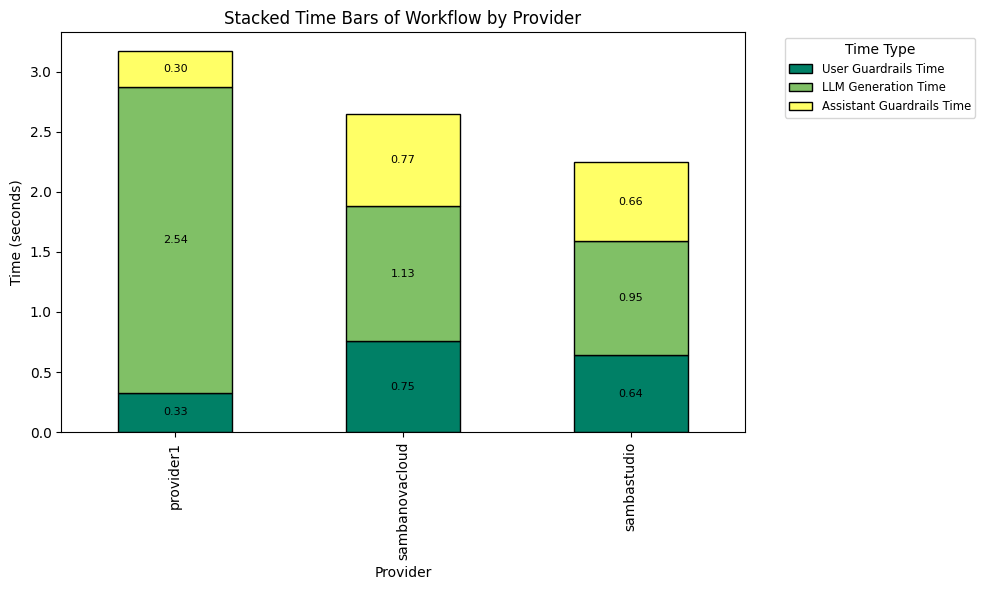

In [72]:
plot_comparison_stacked_barplots(df_metrics_short_prompts)

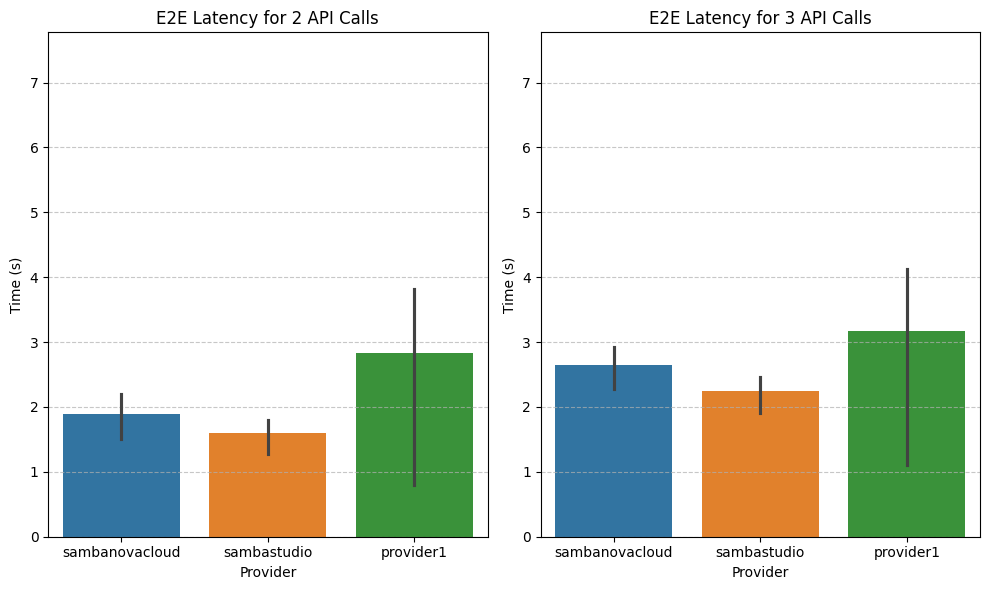

In [73]:
plot_comparison_barcharts(df_metrics_short_prompts)

# Benchamark with long prompts >1K

In [ ]:
long_prompts=[
    """can you summarize the following article in 5000 characters, then create a bullet point list of the 100 top interesting facts:
    The Very Large Telescope (VLT) is an astronomical facility operated since 1998 by the European Southern Observatory, located on Cerro Paranal in the Atacama Desert of northern Chile. It consists of four individual telescopes, each equipped with a primary mirror that measures 8.2 metres (27 ft) in diameter. These optical telescopes, named Antu, Kueyen, Melipal, and Yepun (all words for astronomical objects in the Mapuche language), are generally used separately but can be combined to achieve a very high angular resolution.[1] The VLT array is also complemented by four movable Auxiliary Telescopes (ATs) with 1.8-metre (5.9 ft) apertures.
    The VLT is capable of observing both visible and infrared wavelengths. Each individual telescope can detect objects that are roughly four billion times fainter than what can be seen with the naked eye. When all the telescopes are combined, the facility can achieve an angular resolution of approximately 0.002 arcsecond. In single telescope mode, the angular resolution is about 0.05 arcseconds.[2]
    The VLT is one of the most productive facilities for astronomy, second only to the Hubble Space Telescope in terms of the number of scientific papers produced from facilities operating at visible wavelengths.[3] Some of the pioneering observations made using the VLT include the first direct image of an exoplanet, the tracking of stars orbiting around the supermassive black hole at the centre of the Milky Way, and observations of the afterglow of the furthest known gamma-ray burst.[4]
    General information
    VLT's four Unit Telescopes
    The VLT consists of an arrangement of four large, 8.2-metre (27 ft) diameter telescopes (called Unit Telescopes or UTs) with optical elements that can combine them into an astronomical interferometer (VLTI), which is used to resolve small objects. The interferometer also includes a set of four 1.8-metre (5.9 ft) diameter movable telescopes dedicated to interferometric observations. The first of the UTs started operating in May 1998 and was offered to the astronomical community on 1 April 1999. The other telescopes became operational in 1999 and 2000, enabling multi-telescope VLT capability. Four 1.8-metre Auxiliary Telescopes (ATs) have been added to the VLTI to make it available when the UTs are being used for other projects. These ATs were installed and became operational between 2004 and 2007.[1]
    The VLT's 8.2-meter telescopes were originally designed to operate in three modes:[5]
    as a set of four independent telescopes (this is the primary mode of operation).
    as a single large coherent interferometric instrument (the VLT Interferometer or VLTI), for extra resolution. This mode is used for observations of relatively bright sources with small angular extent.
    as a single large incoherent instrument, for extra light-gathering capacity. The instrumentation required to obtain a combined incoherent focus was not originally built. In 2009, new instrumentation proposals were put forward to potentially make that observing mode available.[6] Multiple telescopes are sometimes independently pointed at the same object, either to increase the total light-gathering power or to provide simultaneous observations with complementary instruments.
    Unit telescopes
    Laser used for adaptive optics. It excites sodium atoms in the atmosphere and creates a laser guide star.
    Upgrading Yepun (UT4) with the "Adaptive Optics Facility" in 2012[8]
    Unit telescope undergoing inspection[7]
    The UTs are equipped with a large set of instruments permitting observations to be performed from the near-ultraviolet to the mid-infrared (i.e. a large fraction of the light wavelengths accessible from the surface of the Earth), with the full range of techniques including high-resolution spectroscopy, multi-object spectroscopy, imaging, and high-resolution imaging. In particular, the VLT has several adaptive optics systems, which correct for the effects of atmospheric turbulence, providing images almost as sharp as if the telescope were in space. In the near-infrared, the adaptive optics images of the VLT are up to three times sharper than those of the Hubble Space Telescope, and the spectroscopic resolution is many times better than Hubble. The VLTs are noted for their high level of observing efficiency and automation.
    The primary mirrors of the UTs are 8.2 metres (26.9 ft) in diameter but, in practice, the pupil of the telescopes is defined by their secondary mirrors, effectively reducing the usable diameter to 8.0 metres (26.2 ft) at the Nasmyth focus and 8.1 metres (26.6 ft) at the Cassegrain focus
    """,
    """
    SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment. SambaNova Systems is a U.S.-based company focused on building advanced systems for artificial intelligence (AI) and machine learning (ML) workloads. It was founded in 2017 by Rodrigo Liang, Kunle Olukotun, and Chris Ré, all of whom have deep roots in computer architecture, AI, and academia. The company's mission is to revolutionize the AI hardware and software ecosystem by offering integrated solutions that accelerate AI development and deployment.
    """
]
benchmark_results_long_prompts = run_benchmark(long_prompts, 15)

In [64]:
df_metrics_long_prompts = get_metrics_as_table(benchmark_results_long_prompts)
df_stats_long_prompts = get_stats(df_metrics_long_prompts)
df_stats_long_prompts

user_guardrails_time                                \
                               mean       std       min       max   
Provider                                                            
provider1                  0.305821  0.072487  0.210574  0.616519   
sambanovacloud             0.812903  0.077341  0.713671  0.988686   
sambastudio                0.663617  0.030838  0.626218  0.745336   

               llm_generation_time                                \
                              mean       std       min       max   
Provider                                                           
provider1                 3.375570  2.534508  0.718217  7.423581   
sambanovacloud            1.287172  0.459661  0.766584  1.868346   
sambastudio               1.164506  0.477047  0.667619  1.666866   

               assistant_guardrails_time                                \
                                    mean       std       min       max   
Provider                                                                 
provider1                       0.463184  0.199618  0.202575  0.774876   
sambanovacloud                  0.769935  0.040146  0.713285  0.885549   
sambastudio                     0.652583  0.034409  0.616779  0.746178   

               e2e_2_calls_time                                \
                           mean       std       min       max   
Provider                                                        
provider1              3.681392  2.541044  1.022479  7.997341   
sambanovacloud         2.100075  0.485490  1.514951  2.774487   
sambastudio            1.828123  0.477673  1.301018  2.399510   

               e2e_3_calls_time                                
                           mean       std       min       max  
Provider                                                       
provider1              4.144576  2.714326  1.243489  8.719428  
sambanovacloud         2.870011  0.474086  2.312371  3.553892  
sambastudio            2.480706  0.480497  1.955870  3.047215

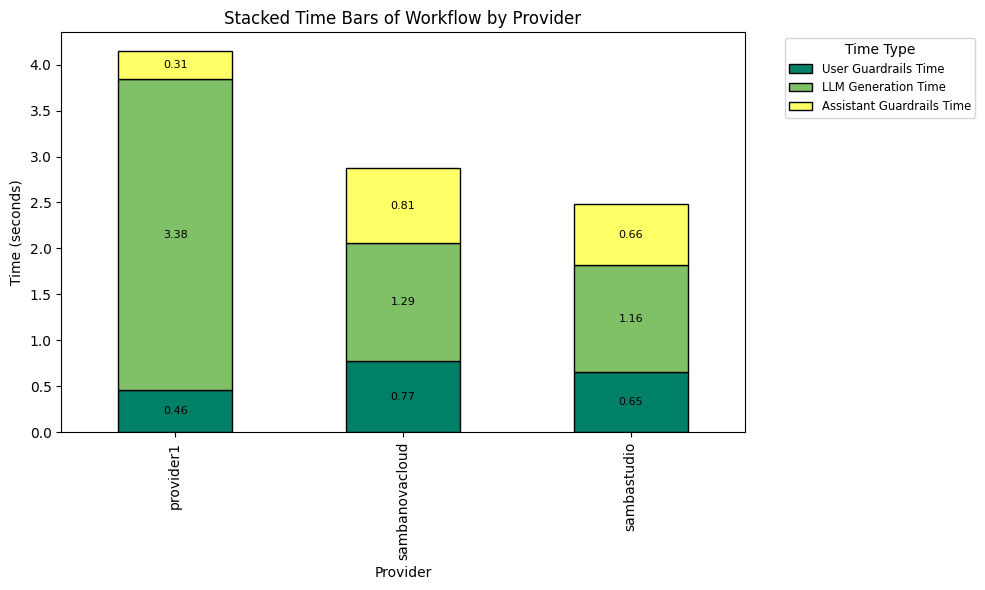

In [65]:
plot_comparison_stacked_barplots(df_metrics_long_prompts)

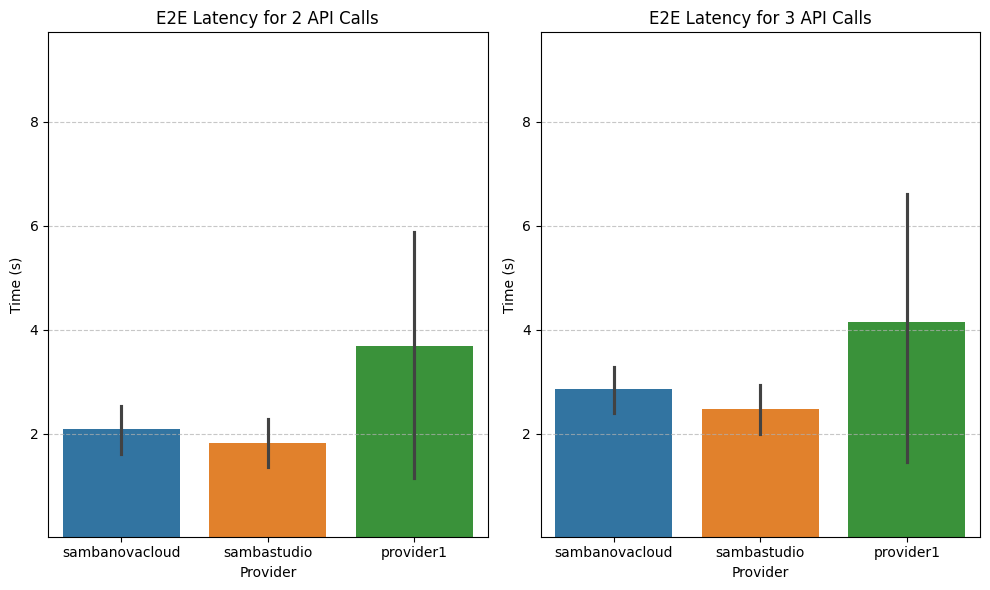

In [66]:
plot_comparison_barcharts(df_metrics_long_prompts)

In [9]:
long_prompts_2 = [""" Please sumarize the following article in less than 1000 words
The James Webb Space Telescope (JWST) is a space telescope designed to conduct infrared astronomy. As the largest telescope in space, it is equipped with high-resolution and high-sensitivity instruments, allowing it to view objects too old, distant, or faint for the Hubble Space Telescope.[9] This enables investigations across many fields of astronomy and cosmology, such as observation of the first stars and the formation of the first galaxies, and detailed atmospheric characterization of potentially habitable exoplanets.[10][11][12]
Although the Webb's mirror diameter is 2.7 times larger than that of the Hubble Space Telescope, it produces images of comparable sharpness because it observes in the longer-wavelength infrared spectrum. The longer the wavelength of the spectrum, the larger the information-gathering surface required (mirrors in the infrared spectrum or antenna area in the millimeter and radio ranges) for an image comparable in clarity to the visible spectrum of the Hubble Space Telescope.
The Webb was launched on 25 December 2021 on an Ariane 5 rocket from Kourou, French Guiana. In January 2022 it arrived at its destination, a solar orbit near the Sun–Earth L2 Lagrange point, about 1.5 million kilometers (930,000 mi) from Earth. The telescope's first image was released to the public on 11 July 2022.[13]
The U.S. National Aeronautics and Space Administration (NASA) led Webb's design and development and partnered with two main agencies: the European Space Agency (ESA) and the Canadian Space Agency (CSA). The NASA Goddard Space Flight Center in Maryland managed telescope development, while the Space Telescope Science Institute in Baltimore on the Homewood Campus of Johns Hopkins University operates Webb. The primary contractor for the project was Northrop Grumman.
The telescope is named after James E. Webb, who was the administrator of NASA from 1961 to 1968 during the Mercury, Gemini, and Apollo programs.
Webb's primary mirror consists of 18 hexagonal mirror segments made of gold-plated beryllium, which together create a 6.5-meter-diameter (21 ft) mirror, compared with Hubble's 2.4 m (7 ft 10 in). This gives Webb a light-collecting area of about 25 m2 (270 sq ft), about six times that of Hubble. Unlike Hubble, which observes in the near ultraviolet and visible (0.1 to 0.8 μm), and near infrared (0.8–2.5 μm)[14] spectra, Webb observes a lower frequency range, from long-wavelength visible light (red) through mid-infrared (0.6–28.5 μm).[15] The telescope must be kept extremely cold, below 50 K (−223 °C; −370 °F), so that the infrared light emitted by the telescope itself does not interfere with the collected light. Its five-layer sunshield protects it from warming by the Sun, Earth, and Moon.
Initial designs for the telescope, then named the Next Generation Space Telescope, began in 1996. Two concept studies were commissioned in 1999, for a potential launch in 2007 and a US$1 billion budget. The program was plagued with enormous cost overruns and delays. A major redesign was accomplished in 2005, with construction completed in 2016, followed by years of exhaustive testing, at a total cost of US$10 billion.
Features
The mass of the James Webb Space Telescope (JWST) is about half that of the Hubble Space Telescope. Webb has a 6.5-meter-diameter (21-foot) gold-coated beryllium primary mirror made up of 18 separate hexagonal mirrors. The mirror has a polished area of 26.3 m2 (283 sq ft), of which 0.9 m2 (9.7 sq ft) is obscured by the secondary support struts,[16] giving a total collecting area of 25.4 m2 (273 sq ft). This is over six times larger than the collecting area of Hubble's 2.4 m (7.9 ft) diameter mirror, which has a collecting area of 4.0 m2 (43 sq ft). The mirror has a gold coating to provide infrared reflectivity and this is covered by a thin layer of glass for durability.[17]
Webb is designed primarily for near-infrared astronomy, but can also see orange and red visible light, as well as the mid-infrared region, depending on the instrument being used.[10][11] It can detect objects up to 100 times fainter than Hubble can, and objects much earlier in the history of the universe, back to redshift z≈20 (about 180 million years cosmic time after the Big Bang).[18] For comparison, the earliest stars are thought to have formed between z≈30 and z≈20 (100–180 million years cosmic time),[19] and the first galaxies may have formed around redshift z≈15 (about 270 million years cosmic time). Hubble is unable to see further back than very early reionization[20][21] at about z≈11.1 (galaxy GN-z11, 400 million years cosmic time).[22][23][18]
The design emphasizes the near to mid-infrared for several reasons:
high-redshift (very early and distant) objects have their visible emissions shifted into the infrared, and therefore their light can be observed only via infrared astronomy;[14]
infrared light passes more easily through dust clouds than visible light;[14]
colder objects such as debris disks and planets emit most strongly in the infrared;
these infrared bands are difficult to study from the ground or by existing space telescopes such as Hubble.
Rough plot of Earth's atmospheric absorption (or opacity) to various wavelengths of electromagnetic radiation, including visible light
Ground-based telescopes must look through Earth's atmosphere, which is opaque in many infrared bands (see figure at right). Even where the atmosphere is transparent, many of the target chemical compounds, such as water, carbon dioxide, and methane, also exist in the Earth's atmosphere, vastly complicating analysis. Existing space telescopes such as Hubble cannot study these bands since their mirrors are insufficiently cool (the Hubble mirror is maintained at about 15 °C [288 K; 59 °F]) which means that the telescope itself radiates strongly in the relevant infrared bands.[24]
Webb can also observe objects in the Solar System at an angle of more than 85° from the Sun and having an apparent angular rate of motion less than 0.03 arc seconds per second.[a] This includes Mars, Jupiter, Saturn, Uranus, Neptune, Pluto, their satellites, and comets, asteroids and minor planets at or beyond the orbit of Mars. Webb has the near-IR and mid-IR sensitivity to be able to observe virtually all known Kuiper Belt Objects.[19][28] In addition, it can observe opportunistic and unplanned targets within 48 hours of a decision to do so, such as supernovae and gamma ray bursts.[19]
Three-quarter view of the top
Bottom (Sun-facing side)
Location and orbit
Webb operates in a halo orbit, circling around a point in space known as the Sun–Earth L2 Lagrange point, approximately 1,500,000 km (930,000 mi) beyond Earth's orbit around the Sun. Its actual position varies between about 250,000 and 832,000 km (155,000–517,000 mi) from L2 as it orbits, keeping it out of both Earth and Moon's shadow. By way of comparison, Hubble orbits 550 km (340 mi) above Earth's surface, and the Moon is roughly 400,000 km (250,000 mi) from Earth. Objects near this Sun–Earth L2 point can orbit the Sun in synchrony with the Earth, allowing the telescope to remain at a roughly constant distance[29] with continuous orientation of its sunshield and equipment bus toward the Sun, Earth and Moon. Combined with its wide shadow-avoiding orbit, the telescope can simultaneously block incoming heat and light from all three of these bodies and avoid even the smallest changes of temperature from Earth and Moon shadows that would affect the structure, yet still maintain uninterrupted solar power and Earth communications on its sun-facing side. This arrangement keeps the temperature of the spacecraft constant and below the 50 K (−223 °C; −370 °F) necessary for faint infrared observations.[30][31]
Sunshield protection
Main article: James Webb Space Telescope sunshield
Test unit of the sunshield stacked and expanded at the Northrop Grumman facility in California, 2014
To make observations in the infrared spectrum, Webb must be kept under 50 K (−223.2 °C; −369.7 °F); otherwise, infrared radiation from the telescope itself would overwhelm its instruments. Its large sunshield blocks light and heat from the Sun, Earth, and Moon, and its position near the Sun–Earth L2 keeps all three bodies on the same side of the spacecraft at all times.[32] Its halo orbit around the L2 point avoids the shadow of the Earth and Moon, maintaining a constant environment for the sunshield and solar arrays.[29] The resulting stable temperature for the structures on the dark side is critical to maintaining precise alignment of the primary mirror segments.[30]
The sunshield consists of five layers, each approximately as thin as a human hair.[33] Each layer is made of Kapton E film, coated with aluminum on both sides. The two outermost layers have an additional coating of doped silicon on the Sun-facing sides, to better reflect the Sun's heat back into space.[30] Accidental tears of the delicate film structure during deployment testing in 2018 led to further delays to the telescope deployment.[34]
The sunshield was designed to be folded twelve times so that it would fit within the Ariane 5 rocket's payload fairing, which is 4.57 m (15.0 ft) in diameter, and 16.19 m (53.1 ft) long. The shield's fully deployed dimensions were planned as 14.162 m × 21.197 m (46.46 ft × 69.54 ft).[35]
Keeping within the shadow of the sunshield limits the field of regard of Webb at any given time. The telescope can see 40 percent of the sky from any one position, but can see all of the sky over a period of six months.[36]
Optics
Main article: Optical Telescope Element
Engineers cleaning a test mirror with carbon dioxide snow, 2015
Main mirror assembly from the front with primary mirrors attached, November 2016
Diffraction spikes due to mirror segments and spider color-coded
Webb's primary mirror is a 6.5 m (21 ft)-diameter gold-coated beryllium reflector with a collecting area of 25.4 m2 (273 sq ft). If it had been designed as a single, large mirror, it would have been too large for existing launch vehicles. The mirror is therefore composed of 18 hexagonal segments (a technique pioneered by Guido Horn d'Arturo), which unfolded after the telescope was launched. Image plane wavefront sensing through phase retrieval is used to position the mirror segments in the correct location using precise actuators. Subsequent to this initial configuration, they only need occasional updates every few days to retain optimal focus.[37] This is unlike terrestrial telescopes, for example the Keck telescopes, which continually adjust their mirror segments using active optics to overcome the effects of gravitational and wind loading.[38] The Webb telescope uses 132 small actuation motors to position and adjust the optics.[39] The actuators can position the mirror with 10 nanometer accuracy.[40]
Webb's optical design is a three-mirror anastigmat,[41] which makes use of curved secondary and tertiary mirrors to deliver images that are free from optical aberrations over a wide field. The secondary mirror is 0.74 m (2.4 ft) in diameter. In addition, there is a fine steering mirror which can adjust its position many times per second to provide image stabilization. Point light sources in images taken by Webb have six diffraction spikes plus two fainter ones, due to the hexagonal shape of the primary mirror segments.[42]
Scientific instruments
NIRCam wrapped up in 2013
The Calibration Assembly, one component of the NIRSpec instrument
MIRI
The Integrated Science Instrument Module (ISIM) is a framework that provides electrical power, computing resources, cooling capability as well as structural stability to the Webb telescope. It is made with bonded graphite-epoxy composite attached to the underside of Webb's telescope structure. The ISIM holds the four science instruments and a guide camera.[43]
NIRCam (Near Infrared Camera) is an infrared imager which has spectral coverage ranging from the edge of the visible (0.6 μm) through to the near infrared (5 μm).[44][45] There are 10 sensors each of 4 megapixels. NIRCam serves as the observatory's wavefront sensor, which is required for wavefront sensing and control activities, used to align and focus the main mirror segments. NIRCam was built by a team led by the University of Arizona, with principal investigator Marcia J. Rieke.[46]
NIRSpec (Near Infrared Spectrograph) performs spectroscopy over the same wavelength range. It was built by the European Space Agency (ESA) at ESTEC in Noordwijk, Netherlands. The leading development team includes members from Airbus Defence and Space, Ottobrunn and Friedrichshafen, Germany, and the Goddard Space Flight Center; with Pierre Ferruit (École normale supérieure de Lyon) as NIRSpec project scientist. The NIRSpec design provides three observing modes: a low-resolution mode using a prism, an R~1000 multi-object mode, and an R~2700 integral field unit or long-slit spectroscopy mode. Switching of the modes is done by operating a wavelength preselection mechanism called the Filter Wheel Assembly, and selecting a corresponding dispersive element (prism or grating) using the Grating Wheel Assembly mechanism. Both mechanisms are based on the successful ISOPHOT wheel mechanisms of the Infrared Space Observatory. The multi-object mode relies on a complex micro-shutter mechanism to allow for simultaneous observations of hundreds of individual objects anywhere in NIRSpec's field of view. There are two sensors, each of 4 megapixels.[47]
MIRI (Mid-Infrared Instrument) measures the mid-to-long-infrared wavelength range from 5 to 27 μm.[48][49] It contains both a mid-infrared camera and an imaging spectrometer.[50] MIRI was developed as a collaboration between NASA and a consortium of European countries, and is led by George Rieke (University of Arizona) and Gillian Wright (UK Astronomy Technology Centre, Edinburgh, Scotland).[46] The temperature of the MIRI must not exceed 6 K (−267 °C; −449 °F): a helium gas mechanical cooler sited on the warm side of the environmental shield provides this cooling.[51]
FGS/NIRISS (Fine Guidance Sensor and Near Infrared Imager and Slitless Spectrograph), led by the Canadian Space Agency (CSA) under project scientist John Hutchings (Herzberg Astronomy and Astrophysics Research Centre), is used to stabilize the line-of-sight of the observatory during science observations. Measurements by the FGS are used both to control the overall orientation of the spacecraft and to drive the fine steering mirror for image stabilization. The CSA also provided a Near Infrared Imager and Slitless Spectrograph (NIRISS) module for astronomical imaging and spectroscopy in the 0.8 to 5 μm wavelength range, led by principal investigator René Doyon[52] at the Université de Montréal.[46] Although they are often referred together as a unit, the NIRISS and FGS serve entirely different purposes, with one being a scientific instrument and the other being a part of the observatory's support infrastructure.[53]
NIRCam and MIRI feature starlight-blocking coronagraphs for observation of faint targets such as extrasolar planets and circumstellar disks very close to bright stars.[49]
Spacecraft bus
Main article: Spacecraft bus (James Webb Space Telescope)
Diagram of the spacecraft bus. The solar panel is in green and the light purple panels are radiators.
The spacecraft bus is the primary support component of the JWST, hosting a multitude of computing, communication, electric power, propulsion, and structural parts.[54] Along with the sunshield, it forms the spacecraft element of the space telescope.[55][56] The spacecraft bus is on the Sun-facing "warm" side of the sunshield and operates at a temperature of about 300 K (27 °C; 80 °F).[55]
The structure of the spacecraft bus has a mass of 350 kg (770 lb), and must support the 6,200 kg (13,700 lb) space telescope. It is made primarily of graphite composite material.[57] The assembly was completed in California in 2015. It was integrated with the rest of the space telescope leading to its 2021 launch. The spacecraft bus can rotate the telescope with a pointing precision of one arcsecond, and isolates vibration to two milliarcseconds.[58]
Webb has two pairs of rocket engines (one pair for redundancy) to make course corrections on the way to L2 and for station keeping – maintaining the correct position in the halo orbit. Eight smaller thrusters are used for attitude control – the correct pointing of the spacecraft.[59] The engines use hydrazine fuel (159 liters or 42 U.S. gallons at launch) and dinitrogen tetroxide as oxidizer (79.5 liters or 21.0 U.S. gallons at launch).[60]
Servicing
Webb is not intended to be serviced in space. A crewed mission to repair or upgrade the observatory, as was done for Hubble, would not be possible,[61] and according to NASA Associate Administrator Thomas Zurbuchen, despite best efforts, an uncrewed remote mission was found to be beyond available technology at the time Webb was designed.[62] During the long Webb testing period, NASA officials referred to the idea of a servicing mission, but no plans were announced.[63][64] Since the successful launch, NASA has stated that nevertheless limited accommodation was made to facilitate future servicing missions. These accommodations included precise guidance markers in the form of crosses on the surface of Webb, for use by remote servicing missions, as well as refillable fuel tanks, removable heat protectors, and accessible attachment points.[65][62]
Software
Ilana Dashevsky and Vicki Balzano write that Webb uses a modified version of JavaScript, called Nombas ScriptEase 5.00e, for its operations; it follows the ECMAScript standard and "allows for a modular design flow, where on-board scripts call lower-level scripts that are defined as functions". "The JWST science operations will be driven by ASCII (instead of binary command blocks) on-board scripts, written in a customized version of JavaScript. The script interpreter is run by the flight software, which is written in the programming language C++. The flight software operates the spacecraft and the science instruments."[66][67]
Comparison with other telescopes
Comparison with the Hubble Space Telescope primary mirror
Primary mirror size comparison between Webb and Hubble
The desire for a large infrared space telescope traces back decades. In the United States, the Space Infrared Telescope Facility (later called the Spitzer Space Telescope) was planned while the Space Shuttle was in development, and the potential for infrared astronomy was acknowledged at that time.[68] Unlike ground telescopes, space observatories are free from atmospheric absorption of infrared light. Space observatories opened a "new sky" for astronomers.
However, there is a challenge involved in the design of infrared telescopes: they need to stay extremely cold, and the longer the wavelength of infrared, the colder they need to be. If not, the background heat of the device itself overwhelms the detectors, making it effectively blind. This can be overcome by careful design. One method is to put the key instruments in a dewar with an extremely cold substance, such as liquid helium. The coolant will slowly vaporize, limiting the lifetime of the instrument from as short as a few months to a few years at most.[24]
It is also possible to maintain a low temperature by designing the spacecraft to enable near-infrared observations without a supply of coolant, as with the extended missions of the Spitzer Space Telescope and the Wide-field Infrared Survey Explorer, which operated at reduced capacity after coolant depletion. Another example is Hubble's Near Infrared Camera and Multi-Object Spectrometer (NICMOS) instrument, which started out using a block of nitrogen ice that depleted after a couple of years, but was then replaced during the STS-109 servicing mission with a cryocooler that worked continuously. The Webb Space Telescope is designed to cool itself without a dewar, using a combination of sunshields and radiators, with the mid-infrared instrument using an additional cryocooler.[69]
Selected space telescopes and instruments[70]
Name	Launch year	Wavelength
(μm)	Aperture
(m)	Cooling
Spacelab Infrared Telescope (IRT)	1985	1.7–118	0.15	Helium
Infrared Space Observatory (ISO)[71]	1995	2.5–240	0.60	Helium
Hubble Space Telescope Imaging Spectrograph (STIS)	1997	0.115–1.03	2.4	Passive
Hubble Near Infrared Camera and Multi-Object Spectrometer (NICMOS)	1997	0.8–2.4	2.4	Nitrogen, later cryocooler
Spitzer Space Telescope	2003	3–180	0.85	Helium
Hubble Wide Field Camera 3 (WFC3)	2009	0.2–1.7	2.4	Passive and thermo-electric[72]
Herschel Space Observatory	2009	55–672	3.5	Helium
James Webb Space Telescope	2021	0.6–28.5	6.5	Passive and cryocooler (MIRI)
Webb's delays and cost increases have been compared to those of its predecessor, the Hubble Space Telescope. When Hubble formally started in 1972, it had an estimated development cost of US$300 million (equivalent to $2,185,203,000 in 2023), but by the time it was sent into orbit in 1990, the cost was about four times that. In addition, new instruments and servicing missions increased the cost to at least US$9 billion by 2006[73] (equivalent to $13,602,509,000 in 2023).
Development history
For a chronological guide, see Timeline of the James Webb Space Telescope.
Background (development to 2003)
Major Milestones
Year	Milestone
1996	Next Generation Space Telescope project first proposed (mirror size: 8 m)
2001	NEXUS Space Telescope, a precursor to the Next Generation Space Telescope, cancelled[74]
2002	Proposed project renamed James Webb Space Telescope, (mirror size reduced to 6 m)
2003	Northrop Grumman awarded contract to build telescope
2007	Memorandum of Understanding signed between NASA and ESA[75]
2010	Mission Critical Design Review (MCDR) passed
2011	Proposed cancellation
2016	Final assembly completed
25 December 2021	Launch
Discussions of a Hubble follow-on started in the 1980s, but serious planning began in the early 1990s.[76] The Hi-Z telescope concept was developed between 1989 and 1994:[77] a fully baffled[b] 4 m (13 ft) aperture infrared telescope that would recede to an orbit at 3 Astronomical unit (AU).[78] This distant orbit would have benefited from reduced light noise from zodiacal dust.[78] Other early plans called for a NEXUS precursor telescope mission.[79][80]
Correcting the flawed optics of the Hubble Space Telescope (HST) in its first years played a significant role in the birth of Webb.[81] In 1993, NASA conducted STS-61, the Space Shuttle mission that replaced HST's camera and installed a retrofit for its imaging spectrograph to compensate for the spherical aberration in its primary mirror.
The HST & Beyond Committee was formed in 1994 "to study possible missions and programs for optical-ultraviolet astronomy in space for the first decades of the 21st century."[82] Emboldened by HST's success, its 1996 report explored the concept of a larger and much colder, infrared-sensitive telescope that could reach back in cosmic time to the birth of the first galaxies. This high-priority science goal was beyond the HST's capability because, as a warm telescope, it is blinded by infrared emission from its own optical system. In addition to recommendations to extend the HST mission to 2005 and to develop technologies for finding planets around other stars, NASA embraced the chief recommendation of HST & Beyond[83] for a large, cold space telescope (radiatively cooled far below 0 °C), and began the planning process for the future Webb telescope.
Preparation for the 2000 Astronomy and Astrophysics Decadal Survey (a literature review produced by the United States National Research Council that includes identifying research priorities and making recommendations for the upcoming decade) included further development of the scientific program for what became known as the Next Generation Space Telescope,[84] and advancements in relevant technologies by NASA. As it matured, studying the birth of galaxies in the young universe, and searching for planets around other stars – the prime goals coalesced as "Origins" by HST & Beyond became prominent.
As hoped, the NGST received the highest ranking in the 2000 Decadal Survey.[85]
An administrator of NASA, Dan Goldin, coined the phrase "faster, better, cheaper", and opted for the next big paradigm shift for astronomy, namely, breaking the barrier of a single mirror. That meant going from "eliminate moving parts" to "learn to live with moving parts" (i.e. segmented optics). With the goal to reduce mass density tenfold, silicon carbide with a very thin layer of glass on top was first looked at, but beryllium was selected at the end.[76]
The mid-1990s era of "faster, better, cheaper" produced the NGST concept, with an 8 m (26 ft) aperture to be flown to L2, roughly estimated to cost US$500 million.[86] In 1997, NASA worked with the Goddard Space Flight Center,[87] Ball Aerospace & Technologies,[88] and TRW[89] to conduct technical requirement and cost studies of the three different concepts, and in 1999 selected Lockheed Martin[90] and TRW for preliminary concept studies.[91] Launch was at that time planned for 2007, but the launch date was pushed back many times (see table further down).
In 2002, the project was renamed after NASA's second administrator (1961–1968), James E. Webb (1906–1992).[92] Webb led the agency during the Apollo program and established scientific research as a core NASA activity.[93]
In 2003, NASA awarded TRW the US$824.8 million prime contract for Webb. The design called for a de-scoped 6.1 m (20 ft) primary mirror and a launch date of 2010.[94] Later that year, TRW was acquired by Northrop Grumman in a hostile bid and became Northrop Grumman Space Technology.[91]
Early development and replanning (2003–2007)
Early full-scale model on display at NASA Goddard Space Flight Center (2005)
Development was managed by NASA's Goddard Space Flight Center in Greenbelt, Maryland, with John C. Mather as its project scientist. The primary contractor was Northrop Grumman Aerospace Systems, responsible for developing and building the spacecraft element, which included the satellite bus, sunshield, Deployable Tower Assembly (DTA) which connects the Optical Telescope Element to the spacecraft bus, and the Mid Boom Assembly (MBA) which helps to deploy the large sunshields on orbit,[95] while Ball Aerospace & Technologies was subcontracted to develop and build the OTE itself, and the Integrated Science Instrument Module (ISIM).[43]
Cost growth revealed in spring 2005 led to an August 2005 re-planning.[96] The primary technical outcomes of the re-planning were significant changes in the integration and test plans, a 22-month launch delay (from 2011 to 2013), and elimination of system-level testing for observatory modes at wavelengths shorter than 1.7 μm. Other major features of the observatory were unchanged. Following the re-planning, the project was independently reviewed in April 2006.[citation needed]
In the 2005 re-plan, the life-cycle cost of the project was estimated at US$4.5 billion. This comprised approximately US$3.5 billion for design, development, launch and commissioning, and approximately US$1.0 billion for ten years of operations.[96] The ESA agreed in 2004 to contributing about €300 million, including the launch.[97] The CSA pledged CA$39 million in 2007[98] and in 2012 delivered its contributions in equipment to point the telescope and detect atmospheric conditions on distant planets.[99]
Detailed design and construction (2007–2021)
A JWST mirror segment, 2010
Mirror segments undergoing cryogenic tests at the X-ray & Cryogenic Facility at Marshall Space Flight Center
The assembled telescope following environmental testing
In January 2007, nine of the ten technology development items in the project successfully passed a Non-Advocate Review.[100] These technologies were deemed sufficiently mature to retire significant risks in the project. The remaining technology development item (the MIRI cryocooler) completed its technology maturation milestone in April 2007. This technology review represented the beginning step in the process that ultimately moved the project into its detailed design phase (Phase C). By May 2007, costs were still on target.[101] In March 2008, the project successfully completed its Preliminary Design Review (PDR). In April 2008, the project passed the Non-Advocate Review. Other passed reviews include the Integrated Science Instrument Module review in March 2009, the Optical Telescope Element review completed in October 2009, and the Sunshield review completed in January 2010.[102]
In April 2010, the telescope passed the technical portion of its Mission Critical Design Review (MCDR). Passing the MCDR signified the integrated observatory can meet all science and engineering requirements for its mission.[103] The MCDR encompassed all previous design reviews. The project schedule underwent review during the months following the MCDR, in a process called the Independent Comprehensive Review Panel, which led to a re-plan of the mission aiming for a 2015 launch, but as late as 2018. By 2010, cost over-runs were impacting other projects, though Webb itself remained on schedule.[104]
By 2011, the Webb project was in the final design and fabrication phase (Phase C).
Assembly of the hexagonal segments of the primary mirror, which was done via robotic arm, began in November 2015 and was completed on 3 February 2016. The secondary mirror was installed on 3 March 2016.[105][106] Final construction of the Webb telescope was completed in November 2016, after which extensive testing procedures began.[107]
In March 2018, NASA delayed Webb's launch an additional two years to May 2020 after the telescope's sunshield ripped during a practice deployment and the sunshield's cables did not sufficiently tighten. In June 2018, NASA delayed the launch by an additional 10 months to March 2021, based on the assessment of the independent review board convened after the failed March 2018 test deployment.[108] The review identified that Webb launch and deployment had 344 potential single-point failures – tasks that had no alternative or means of recovery if unsuccessful, and therefore had to succeed for the telescope to work.[109] In August 2019, the mechanical integration of the telescope was completed, something that was scheduled to be done 12 years before in 2007.[110]
After construction was completed, Webb underwent final tests at Northrop Grumman's historic Space Park in Redondo Beach, California.[111] A ship carrying the telescope left California on 26 September 2021, passed through the Panama Canal, and arrived in French Guiana on 12 October 2021.[112]
"""]

In [ ]:
benchmark_results_long_prompts2 = run_benchmark(long_prompts_2, 30, sambanovacloud=False)

In [15]:
df_metrics_long_prompts2 = get_metrics_as_table(benchmark_results_long_prompts2)
df_stats_long_prompts2 = get_stats(df_metrics_long_prompts2)
df_stats_long_prompts2

user_guardrails_time                                \
                            mean       std       min       max   
Provider                                                         
provider1               0.396246  0.076730  0.316241  0.778573   
sambastudio             1.577876  0.096958  1.485599  1.968342   

            llm_generation_time                                \
                           mean       std       min       max   
Provider                                                        
provider1              6.048695  0.869752  4.423609  7.803131   
sambastudio            2.168702  0.187657  2.028167  2.787528   

            assistant_guardrails_time                                \
                                 mean       std       min       max   
Provider                                                              
provider1                    0.571533  0.122974  0.293411  0.736655   
sambastudio                  0.662581  0.052254  0.617510  0.818499   

            e2e_2_calls_time                               e2e_3_calls_time  \
                        mean       std       min       max             mean   
Provider                                                                      
provider1           6.444941  0.856535  4.838195  8.170538         7.016473   
sambastudio         3.746578  0.194642  3.523804  4.291292         4.409159   

                                           
                  std       min       max  
Provider                                   
provider1    0.922711  5.213551  8.830501  
sambastudio  0.199607  4.151857  4.908802

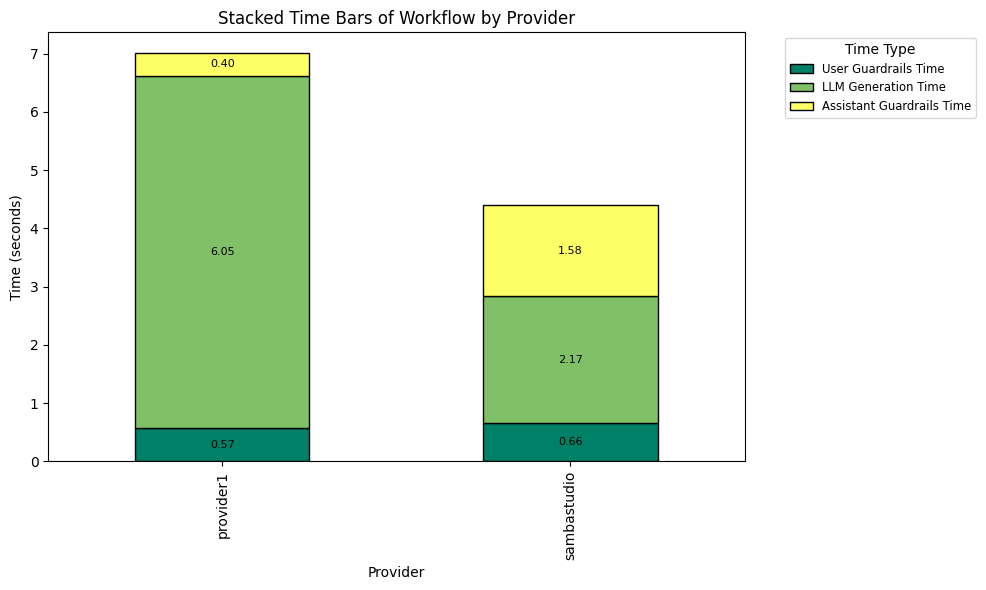

In [16]:
plot_comparison_stacked_barplots(df_metrics_long_prompts2)

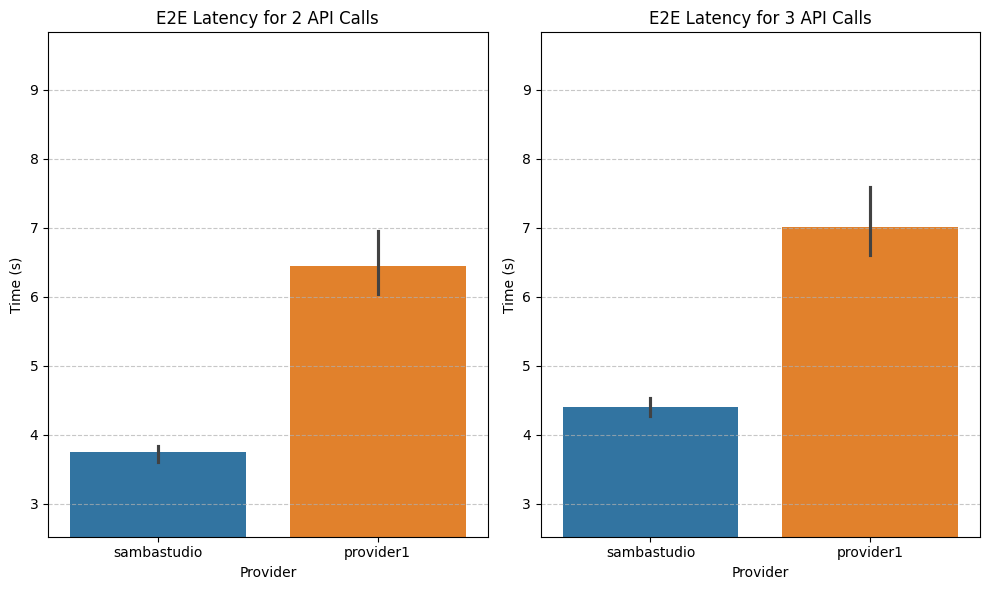

In [17]:
plot_comparison_barcharts(df_metrics_long_prompts2)